In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
import torch
import stackstac
from pystac_client import Client
import boto3
import xarray as xr
import numpy as np
import os
import rioxarray
from src.datamodule import ClayDataModule
from src.model_clay_v1 import ClayMAEModule

/opt/conda/envs/claymodel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
AWS_S3_URL = "s3://naip-analytic/{state}/{year}/{resolution}/rgbir_cog/{block}{subblock}/{name}"
PLATFORM_NAME = "naip"

state = "CA"
year = 2020
resolution = "60cm"

s3 = boto3.client('s3')

bucket_name = 'naip-analytic'
prefix = 'ca/2020/60cm/rgbir_cog/'

response = s3.list_objects_v2(
    Bucket=bucket_name,
    Prefix=prefix,
    Delimiter='/',
    RequestPayer='requester'  # Specify the requester pays parameter
)

blocks = [prefix['Prefix'].split('/')[4] for prefix in response.get('CommonPrefixes', [])]

search_query = {
    "collections": [PLATFORM_NAME],
    "bbox": [-122.6, 37.6, -122.35, 37.85],  # Part of San Francisco, CA
    "datetime": f"{year}-01-01T00:00:00Z/{year+1}-01-01T00:00:00Z",
}

client = Client.open(STAC_API)

items = client.search(**search_query)

stackstac_datasets = []
granule_names = []

# Iterate over the granule names and fetch the corresponding StackSTAC data arrays
for item in items.get_all_items():
    assets = item.assets
    for asset_key, asset in assets.items():
        if '.tif' in asset.href:
            granule_name = asset.href.split('/')[-1]
            for block in blocks:
                aws_s3_url = AWS_S3_URL.format(
                    state=state,
                    year=year,
                    resolution=resolution,
                    block=block,
                    subblock="",
                    name=granule_name,
                )
                if granule_name == aws_s3_url.split('/')[-1]:
                    print(item)

                    dataset = stackstac.stack(item)

                    stackstac_datasets.append(dataset)
                    granule_names.append(granule_name)

                    break
            else:
                print(f"No matching granule found for {granule_name} with any block.")

# Function to tile dataset into 256x256 image chips and drop any excess border regions
def tile_dataset(dataset, granule_name):
    # Reorder dimensions to have (time, band, y, x)
    print(dataset.band)
    dataset = dataset.transpose("time", "band", "y", "x")

    # Crop the dataset to remove excess border regions
    cropped_dataset = dataset.isel(x=slice(1, -1), y=slice(1, -1))

    # Determine the number of tiles in x and y dimensions
    num_x_tiles = cropped_dataset.x.size // 256
    num_y_tiles = cropped_dataset.y.size // 256

    # Iterate over each tile
    for x_idx in range(num_x_tiles):
        for y_idx in range(num_y_tiles):
            # Calculate the coordinates for this tile
            x_start = x_idx * 256
            y_start = y_idx * 256
            x_end = x_start + 256
            y_end = y_start + 256

            # Extract the tile from the cropped dataset
            tile = cropped_dataset.isel(x=slice(x_start, x_end), y=slice(y_start, y_end))
            print(tile.shape)

            # Save the tile as a GeoTIFF
            tile_path = f"{granule_name[:-4]}_{x_idx}_{y_idx}.tif"
            #tile.rio.to_raster(tile_path)


# Tile each dataset
for dataset, granule_name in zip(stackstac_datasets, granule_names):
    tile_dataset(dataset)


In [3]:
ckpt = "../checkpoints/v0.5.3/mae_v0.5.3_epoch-08_val-loss-0.3150.ckpt" # patch 8 x 8
model = ClayMAEModule.load_from_checkpoint(ckpt, metadata_path="../configs/metadata.yaml", shuffle=False, mask_ratio=0.)

/opt/conda/envs/claymodel/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
sum(param.numel() for name, param in model.named_parameters())/1000_000

201.08544

In [5]:
model.eval();

In [6]:
!ls /opt/dlami/nvme/

lost+found


In [7]:
dm = ClayDataModule(data_dir="/home/ubuntu/data", size=64, metadata_path="../configs/metadata.yaml", batch_size=1, num_workers=1)

In [8]:
dm.setup(stage="fit")

Total number of chips: 193


In [9]:
trn_dl = dm.train_dataloader()

In [10]:
iter_dl = iter(trn_dl)

In [11]:
l1 = next(iter_dl)
l2 = next(iter_dl)
linz = next(iter_dl)
naip = next(iter_dl)
s1 = next(iter_dl)
s2 = next(iter_dl)

In [12]:
for sensor in (l1, l2, linz, naip, s1, s2):
    print(sensor["pixels"].shape)

torch.Size([128, 6, 64, 64])
torch.Size([128, 6, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 4, 64, 64])
torch.Size([128, 2, 64, 64])
torch.Size([128, 10, 64, 64])


In [13]:
def create_input_for_model(sensor, dm, device):
    platform =sensor["platform"][0]
    _sensor = {}
    
    _sensor["pixels"] = sensor["pixels"].to(device)
    _sensor["time"] = sensor["time"].to(device)
    _sensor["latlon"] = sensor["latlon"].to(device)
    _sensor["waves"] = torch.tensor(list(dm.metadata[platform].bands.wavelength.values()))
    _sensor["gsd"] = torch.tensor(dm.metadata[platform].gsd)
    return _sensor

In [14]:
platform = naip["platform"][0]
datacube = create_input_for_model(naip, dm, "cuda")

In [15]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

In [16]:
unmsk_patch.shape, unmsk_idx.shape, msk_idx.shape, msk_matrix.shape

(torch.Size([128, 65, 768]),
 torch.Size([128, 64]),
 torch.Size([128, 0]),
 torch.Size([128, 64]))

In [17]:
with torch.no_grad():
    pixels, waves = model.model.decoder(unmsk_patch, 
                                        unmsk_idx, 
                                        msk_idx, 
                                        msk_matrix, 
                                        datacube["time"], 
                                        datacube["latlon"], 
                                        datacube["gsd"], 
                                        datacube["waves"])

In [18]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means)
    stds = np.array(stds)
    means = means.reshape(1, -1, 1, 1)
    stds = stds.reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means

    return denormalized_images

In [19]:
mean = list(dm.metadata[platform].bands.mean.values())
std = list(dm.metadata[platform].bands.std.values())
datacube_pixels = datacube["pixels"].detach().cpu().numpy()
datacube_pixels = denormalize_images(datacube_pixels, mean, std)
if platform in {"naip", "linz"}:
    datacube_pixels = datacube_pixels.astype(np.uint8)

In [20]:
mean, std

([110.16, 115.41, 98.15, 139.04], [47.23, 39.82, 35.43, 49.86])

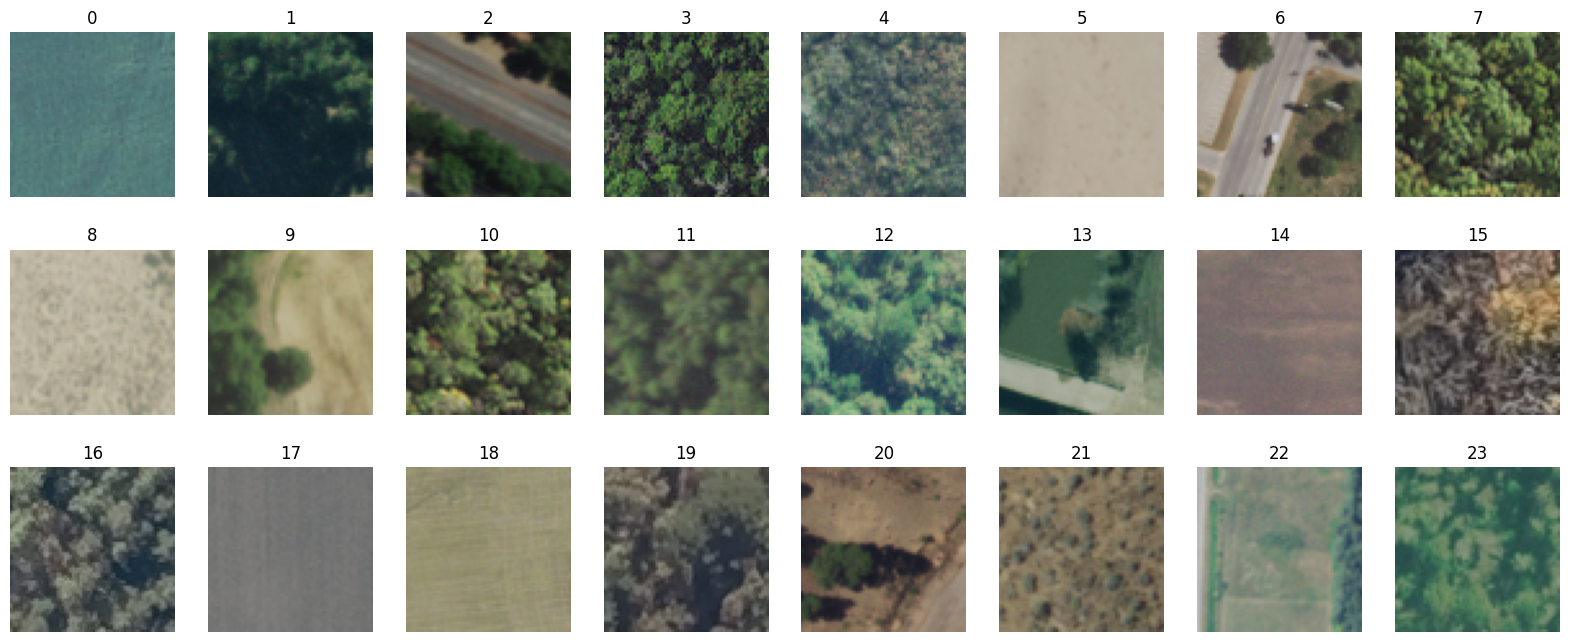

In [21]:
fig, axs = plt.subplots(3, 8, figsize=(20, 8))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(datacube_pixels[idx, :3,...].transpose(1,2,0))
    ax.set_axis_off()
    ax.set_title(idx)

In [22]:
unmsk_embed = rearrange(unmsk_patch[:,1:,:].detach().cpu().numpy(), 
                "b (h w) d-> b d h w", 
                h=8,
                w=8)

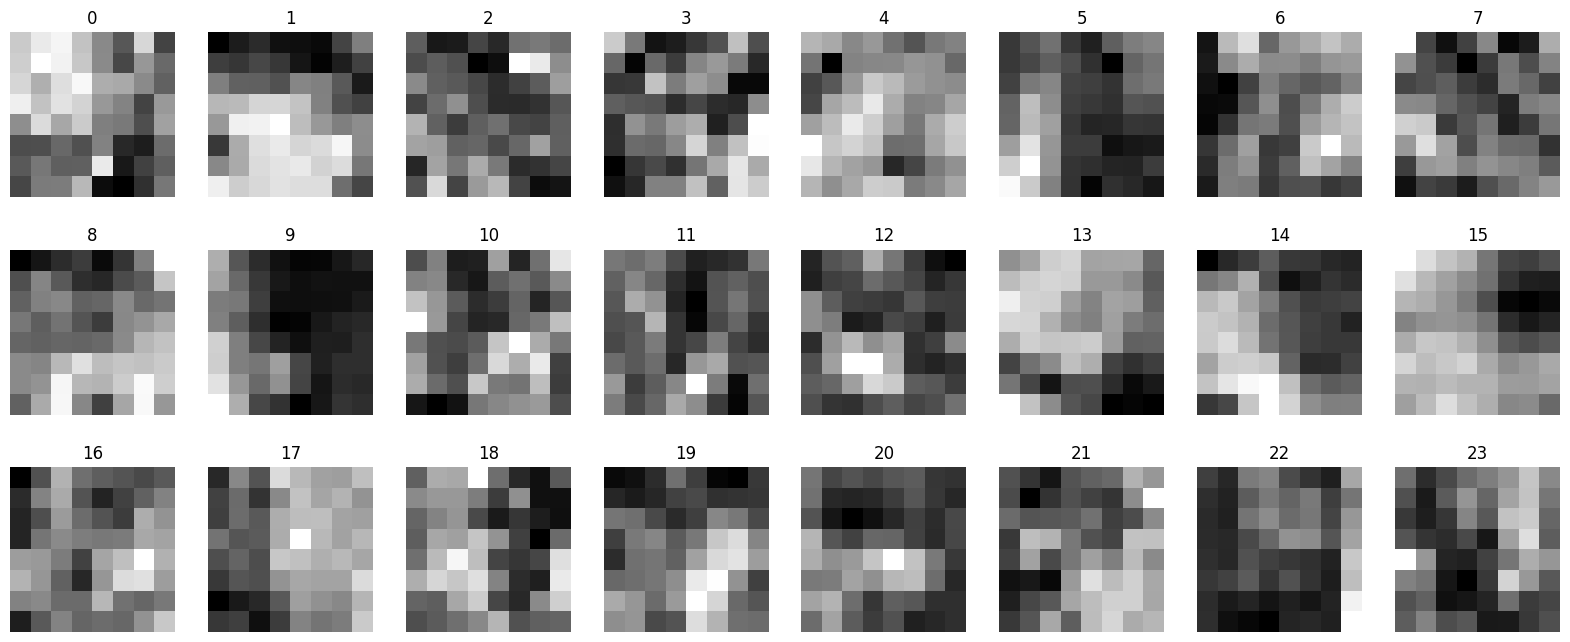

In [23]:
fig, axs = plt.subplots(3, 8, figsize=(20, 8))
embed_dim = 97
for idx,ax in enumerate(axs.flatten()):
    embed = unmsk_embed[idx]
    ax.imshow(embed[embed_dim], cmap="gray")
    ax.set_axis_off()
    ax.set_title(idx)

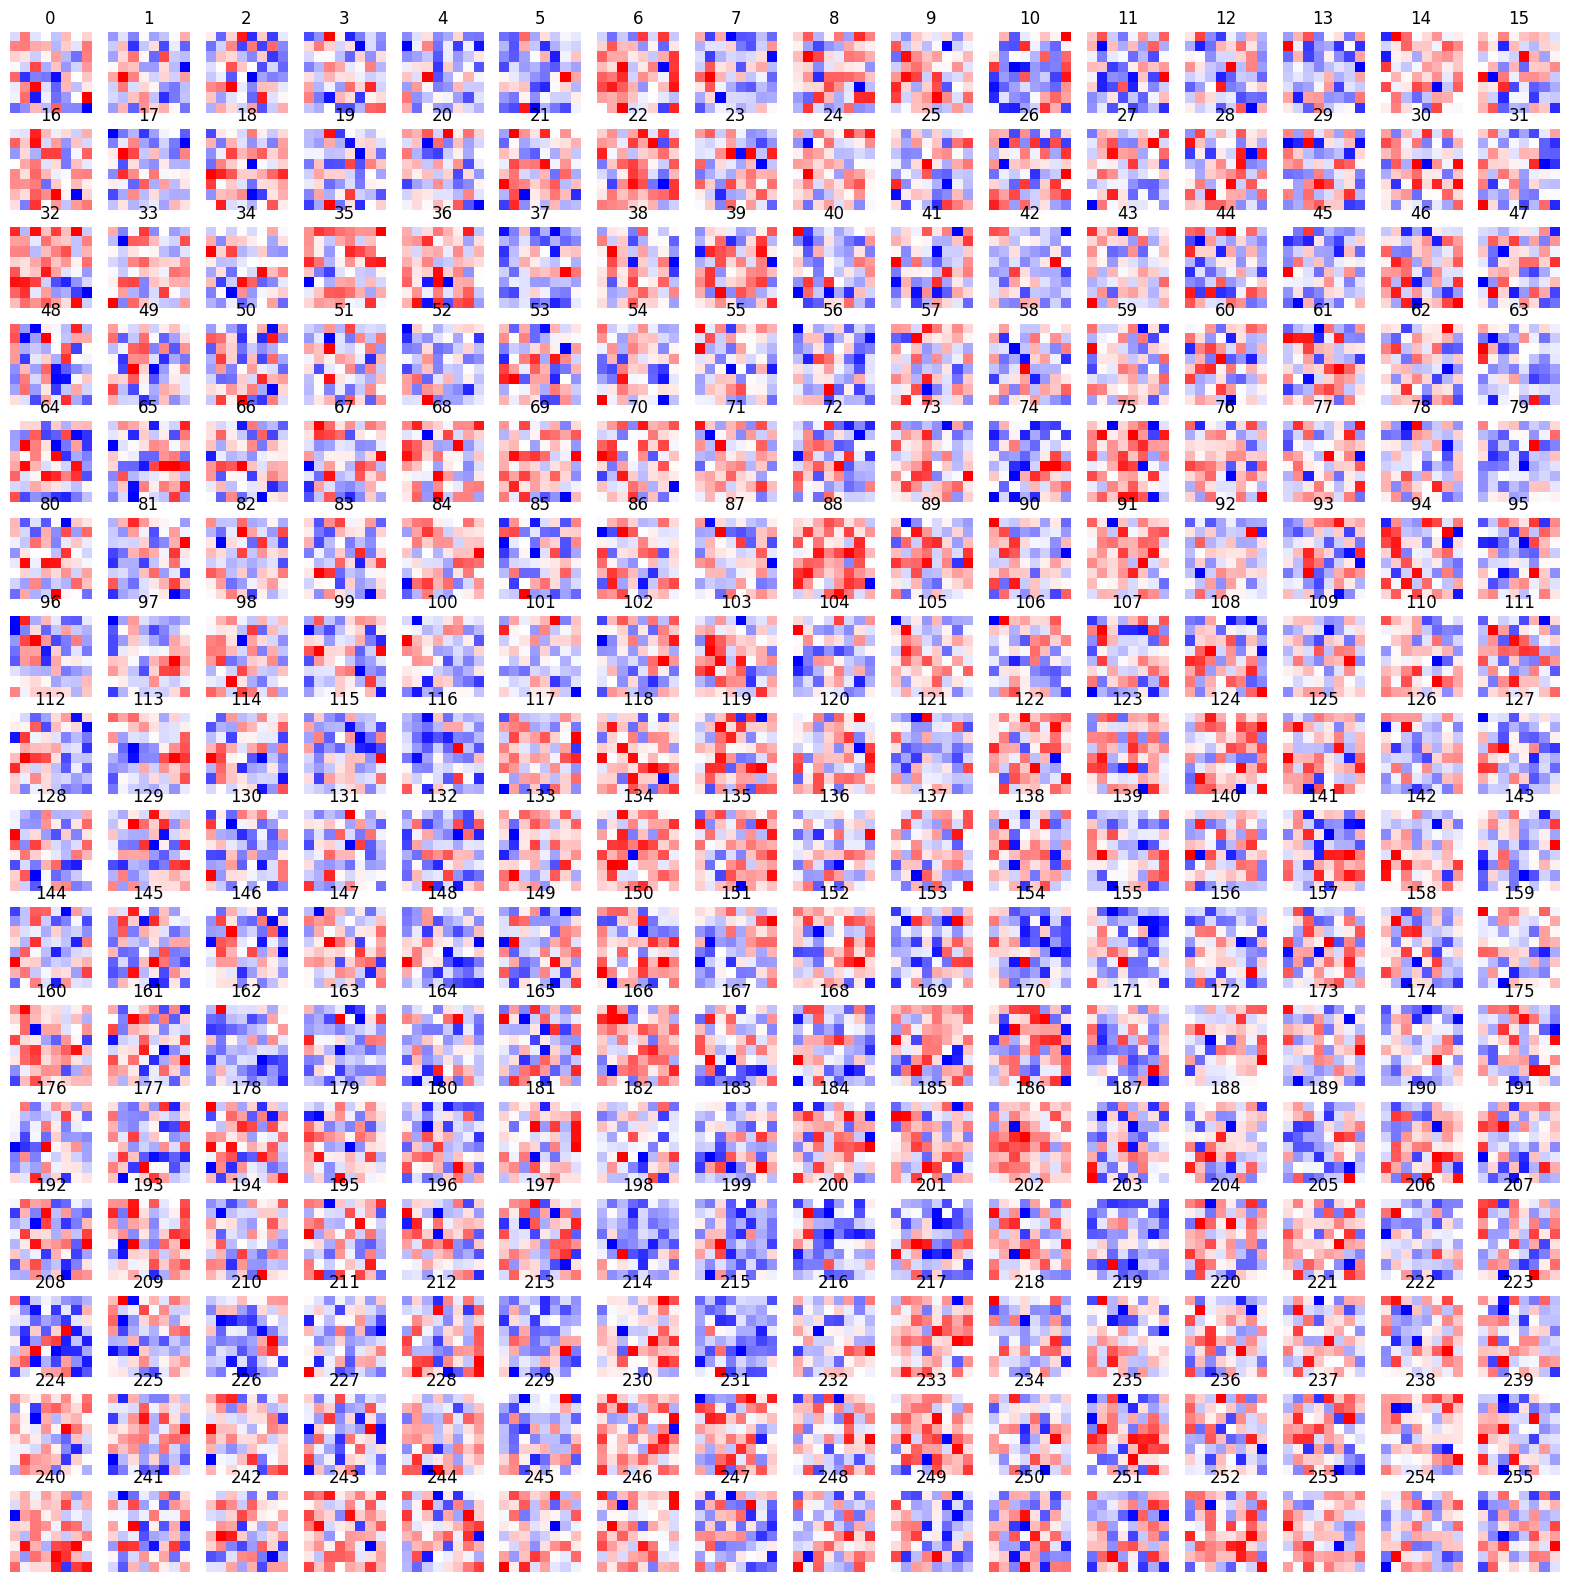

In [24]:
embed = unmsk_embed[16]
fig, axs = plt.subplots(16, 16, figsize=(20, 20))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)